In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('/content/Cleaned_data.csv')
data.head()

,facilities,advantages,BHK,avg_sba,Avg_prics,floors,units,tpa,towers,address
0,19.0,6.565000,2.0,1362.5,0.9749,14.0,908.0,9.625,8.0,"shamshabad,hyderabad"
1,19.0,6.565000,3.0,1652.5,1.2300,14.0,908.0,9.625,8.0,"shamshabad,hyderabad"
2,27.0,7.209091,3.0,2140.0,2.4000,44.0,856.0,5.060,2.0,"nanakramguda,hyderabad"
3,21.0,6.225000,2.0,1420.0,1.1800,16.0,352.0,2.240,1.0,"kondapur,hyderabad"
4,21.0,6.225000,3.0,1850.0,1.5350,16.0,352.0,2.240,1.0,"kondapur,hyderabad"


In [3]:
data.rename(columns={'Avg_prics':'Avg_price','avg_sba':'SBA'},inplace=True)

In [4]:
X = data.drop(columns='Avg_price')
y = data['Avg_price']

In [5]:
y_transformed = np.log1p(y)

<Axes: xlabel='Avg_price', ylabel='Density'>

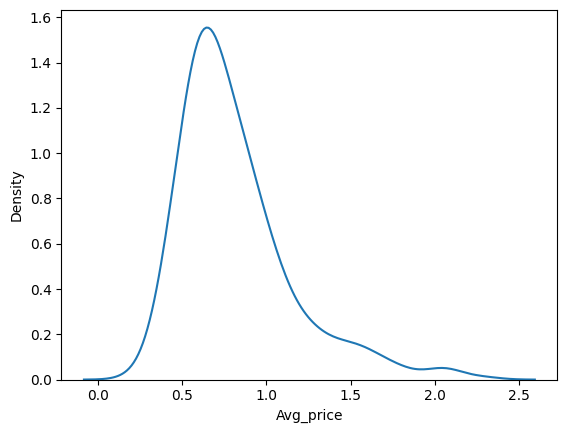

In [6]:
import seaborn as sns
sns.kdeplot(y_transformed)

In [7]:
columns_to_encode = ['address']

In [8]:
# tranformer for column transforming
preprocessor = ColumnTransformer(
    transformers = [
        ('num',StandardScaler(),['facilities','advantages','BHK','SBA','floors','units','tpa','towers']),
        ('cat',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),columns_to_encode)
    ],
    remainder='passthrough'
)

In [9]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',LinearRegression())
])

In [10]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
scores = cross_val_score(pipeline,X,y_transformed,cv=kfold,scoring='r2')

In [11]:
scores.mean()

0.7973485777260831

In [12]:
scores.std()

0.0741385991307477

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [14]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['facilities', 'advantages',
                                                   'BHK', 'SBA', 'floors',
                                                   'units', 'tpa', 'towers']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['address'])])),
                ('regressor', LinearRegression())])

In [15]:
y_pred = pipeline.predict(X_test)

In [16]:
y_pred = np.expm1(y_pred)

In [17]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.21958051629322783

In [18]:
# Function for scores
def scorer(model_name,model):
  output=[]
  output.append(model_name)
  pipeline = Pipeline([
      ('preprocessor',preprocessor),
      ('model',model)
  ])

  kfold = KFold(n_splits=10,shuffle=True,random_state=42)
  scores = cross_val_score(pipeline,X,y_transformed,cv=kfold,scoring='r2')
  output.append(scores.mean())
  X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

  pipeline.fit(X_train,y_train)

  y_pred = pipeline.predict(X_test)

  y_pred = np.expm1(y_pred)

  output.append(mean_absolute_error(np.expm1(y_test),y_pred))

  return output

In [19]:
!pip install neural

In [20]:
from sklearn.linear_model import Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [21]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [22]:
model_output = []
for model_name,model in model_dict.items():
  model_output.append(scorer(model_name,model))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [23]:
model_output

[['linear_reg', 0.7973485777260831, 0.21958051629322783],
 ['svr', 0.7199064845634274, 0.31629844569069565],
 ['ridge', 0.7977873737817991, 0.2199683451321901],
 ['LASSO', -0.03292455154745329, 0.6510378601622495],
 ['decision tree', 0.7009400576341703, 0.3677609589041096],
 ['random forest', 0.8164693540189564, 0.24789775729300093],
 ['extra trees', 0.7967345766333569, 0.2350523392239061],
 ['gradient boosting', 0.8619927582223055, 0.2211182144441092],
 ['adaboost', 0.7753877257269506, 0.2718718718059899],
 ['mlp', -0.5894757028566115, 0.2848697791931429],
 ['xgboost', 0.8410823867115098, 0.22851743925499587]]

In [24]:
model_df = pd.DataFrame(model_output,columns=['model_name','r2_score','score_Std'])
model_df.sort_values(by='r2_score',ascending=False)

,model_name,r2_score,score_Std
7,gradient boosting,0.861993,0.221118
10,xgboost,0.841082,0.228517
5,random forest,0.816469,0.247898
2,ridge,0.797787,0.219968
0,linear_reg,0.797349,0.219581
6,extra trees,0.796735,0.235052
8,adaboost,0.775388,0.271872
1,svr,0.719906,0.316298
4,decision tree,0.700940,0.367761
3,LASSO,-0.032925,0.651038


In [25]:
# tranformer for column transforming
preprocessor = ColumnTransformer(
    transformers = [
        ('num',StandardScaler(),['facilities','advantages','BHK','SBA','floors','units','tpa','towers']),
        ('cat',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),columns_to_encode),
        ('cat1',OneHotEncoder(handle_unknown='ignore',drop='first'),columns_to_encode)
    ],
    remainder='passthrough'
)

In [26]:
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',LinearRegression())
])

In [27]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categ

In [28]:
scores.mean()

0.8640966280875434

In [29]:
scores.std()

0.051277138507702824

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)


In [31]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['facilities', 'advantages',
                                                   'BHK', 'SBA', 'floors',
                                                   'units', 'tpa', 'towers']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['address']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['address'])])),
                ('regressor', LinearRegression())])

In [32]:
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [33]:
y_pred = np.expm1(y_pred)

In [34]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.17437790032373615

In [35]:
model_output = []
for model_name,model in model_dict.items():
  model_output.append(scorer(model_name,model))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categ

In [36]:
model_df1 = pd.DataFrame(model_output,columns=['model_name','r2_score','score_Std'])
model_df1.sort_values(by='r2_score',ascending=False)

,model_name,r2_score,score_Std
7,gradient boosting,0.868362,0.212405
0,linear_reg,0.864097,0.174378
2,ridge,0.858673,0.166859
10,xgboost,0.854186,0.226472
6,extra trees,0.833933,0.240379
5,random forest,0.832055,0.229467
8,adaboost,0.789402,0.276238
9,mlp,0.775934,0.233024
1,svr,0.723902,0.315151
4,decision tree,0.703365,0.364794


In [37]:
from hyperopt import hp, fmin, tpe, Trials, space_eval
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

# Define the search space for hyperparameters
space = {
    'n_estimators': hp.choice('n_estimators', range(10, 1000)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
}

# Function to optimize
def objective(params):
    # Define preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['facilities', 'advantages', 'BHK', 'SBA', 'floors', 'units', 'tpa', 'towers']),
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
            ('cat1', OneHotEncoder(handle_unknown='ignore', drop='first'), columns_to_encode)
        ],
        remainder='passthrough'
    )

    # Define the pipeline including preprocessing and the regressor
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(**params))
    ])

    # Calculate R2 score using cross-validation
    r2_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

    # Return the negative mean R2 score (since fmin minimizes the objective function)
    return -np.mean(r2_scores)

# Run hyperparameter tuning
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

# Extract and print the best hyperparameters found
best_params = space_eval(space, best)
print("Best Hyperparameters:", best_params)

# Calculate R2 score using the best hyperparameters on the entire training set
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(**best_params))
])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_pred = np.expm1(y_pred)
r2_train = r2_score(np.expm1(y_test), y_pred)
print("R2 Score on Training Data with Best Hyperparameters:", r2_train)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



  1%|          | 1/100 [00:00<01:01,  1.62trial/s, best loss: -0.4766351418540541]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

  2%|▏         | 2/100 [00:02<02:25,  1.49s/trial, best loss: -0.5115642345462869]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



  3%|▎         | 3/100 [00:03<02:01,  1.26s/trial, best loss: -0.5167450342066567]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

  4%|▍         | 4/100 [00:04<01:37,  1.02s/trial, best loss: -0.5814504992619854]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

  5%|▌         | 5/100 [00:05<01:46,  1.12s/trial, best loss: -0.5814504992619854]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

  6%|▌         | 6/100 [00:06<01:25,  1.10trial/s, best loss: -0.693876284681173] 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

  7%|▋         | 7/100 [00:09<02:38,  1.70s/trial, best loss: -0.693876284681173]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

  8%|▊         | 8/100 [00:12<03:11,  2.09s/trial, best loss: -0.693876284681173]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

  9%|▉         | 9/100 [00:14<03:22,  2.22s/trial, best loss: -0.693876284681173]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 10%|█         | 10/100 [00:18<04:10,  2.78s/trial, best loss: -0.693876284681173]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 11%|█         | 11/100 [00:22<04:36,  3.11s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 12%|█▏        | 12/100 [00:26<05:01,  3.42s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 13%|█▎        | 13/100 [00:30<05:05,  3.51s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 14%|█▍        | 14/100 [00:33<04:57,  3.45s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 15%|█▌        | 15/100 [00:39<05:51,  4.13s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



 16%|█▌        | 16/100 [00:41<04:37,  3.31s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 17%|█▋        | 17/100 [00:43<04:16,  3.09s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 18%|█▊        | 18/100 [00:47<04:25,  3.24s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



 19%|█▉        | 19/100 [00:47<03:16,  2.43s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 20%|██        | 20/100 [00:51<03:35,  2.70s/trial, best loss: -0.7540613087968647]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 21%|██        | 21/100 [00:52<03:12,  2.44s/trial, best loss: -0.7833443273004459]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 22%|██▏       | 22/100 [00:55<03:02,  2.34s/trial, best loss: -0.7841176884668931]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 23%|██▎       | 23/100 [00:59<03:43,  2.90s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 24%|██▍       | 24/100 [01:01<03:23,  2.68s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 25%|██▌       | 25/100 [01:04<03:35,  2.87s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 26%|██▌       | 26/100 [01:07<03:22,  2.74s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 27%|██▋       | 27/100 [01:10<03:41,  3.04s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 28%|██▊       | 28/100 [01:15<04:04,  3.40s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 29%|██▉       | 29/100 [01:17<03:33,  3.00s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 30%|███       | 30/100 [01:18<02:54,  2.50s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 31%|███       | 31/100 [01:20<02:50,  2.47s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 32%|███▏      | 32/100 [01:21<02:08,  1.90s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 33%|███▎      | 33/100 [01:22<01:48,  1.63s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 34%|███▍      | 34/100 [01:25<02:04,  1.89s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



 35%|███▌      | 35/100 [01:25<01:32,  1.42s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 36%|███▌      | 36/100 [01:27<01:41,  1.59s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 37%|███▋      | 37/100 [01:31<02:38,  2.51s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 38%|███▊      | 38/100 [01:34<02:36,  2.52s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 39%|███▉      | 39/100 [01:35<02:11,  2.15s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 40%|████      | 40/100 [01:39<02:37,  2.63s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 41%|████      | 41/100 [01:43<02:59,  3.04s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 42%|████▏     | 42/100 [01:47<03:03,  3.16s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 43%|████▎     | 43/100 [01:48<02:31,  2.66s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 44%|████▍     | 44/100 [01:51<02:39,  2.84s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 45%|████▌     | 45/100 [01:56<03:05,  3.37s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 46%|████▌     | 46/100 [01:59<02:57,  3.28s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 47%|████▋     | 47/100 [02:00<02:24,  2.73s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 48%|████▊     | 48/100 [02:01<01:46,  2.05s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 49%|████▉     | 49/100 [02:05<02:18,  2.71s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 50%|█████     | 50/100 [02:06<01:49,  2.19s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 51%|█████     | 51/100 [02:08<01:45,  2.15s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 52%|█████▏    | 52/100 [02:11<01:48,  2.26s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 53%|█████▎    | 53/100 [02:12<01:35,  2.04s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 54%|█████▍    | 54/100 [02:15<01:47,  2.34s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 55%|█████▌    | 55/100 [02:18<01:47,  2.38s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 56%|█████▌    | 56/100 [02:19<01:34,  2.15s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 57%|█████▋    | 57/100 [02:21<01:28,  2.07s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 58%|█████▊    | 58/100 [02:25<01:50,  2.64s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 59%|█████▉    | 59/100 [02:27<01:34,  2.31s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 60%|██████    | 60/100 [02:28<01:23,  2.09s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 61%|██████    | 61/100 [02:33<01:47,  2.76s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 62%|██████▏   | 62/100 [02:33<01:22,  2.17s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 63%|██████▎   | 63/100 [02:38<01:51,  3.01s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 64%|██████▍   | 64/100 [02:41<01:40,  2.79s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 65%|██████▌   | 65/100 [02:43<01:28,  2.54s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 66%|██████▌   | 66/100 [02:45<01:23,  2.47s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 67%|██████▋   | 67/100 [02:48<01:30,  2.75s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 68%|██████▊   | 68/100 [02:49<01:06,  2.08s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 69%|██████▉   | 69/100 [02:53<01:23,  2.70s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 70%|███████   | 70/100 [02:55<01:16,  2.54s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 71%|███████   | 71/100 [03:00<01:33,  3.23s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 72%|███████▏  | 72/100 [03:04<01:38,  3.53s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 73%|███████▎  | 73/100 [03:10<01:53,  4.19s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 74%|███████▍  | 74/100 [03:13<01:37,  3.76s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 75%|███████▌  | 75/100 [03:16<01:33,  3.76s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 76%|███████▌  | 76/100 [03:20<01:25,  3.57s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 77%|███████▋  | 77/100 [03:24<01:28,  3.84s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 78%|███████▊  | 78/100 [03:27<01:19,  3.63s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 79%|███████▉  | 79/100 [03:31<01:18,  3.75s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 80%|████████  | 80/100 [03:35<01:12,  3.65s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 81%|████████  | 81/100 [03:37<01:01,  3.25s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 82%|████████▏ | 82/100 [03:40<00:59,  3.33s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



 83%|████████▎ | 83/100 [03:41<00:43,  2.54s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 84%|████████▍ | 84/100 [03:45<00:48,  3.02s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



 85%|████████▌ | 85/100 [03:47<00:37,  2.51s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 86%|████████▌ | 86/100 [03:50<00:38,  2.72s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 87%|████████▋ | 87/100 [03:53<00:38,  2.96s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 88%|████████▊ | 88/100 [03:56<00:34,  2.84s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 89%|████████▉ | 89/100 [04:00<00:36,  3.31s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 90%|█████████ | 90/100 [04:04<00:33,  3.31s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 91%|█████████ | 91/100 [04:08<00:33,  3.67s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 92%|█████████▏| 92/100 [04:12<00:30,  3.85s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 93%|█████████▎| 93/100 [04:15<00:25,  3.60s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 94%|█████████▍| 94/100 [04:17<00:17,  2.91s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 95%|█████████▌| 95/100 [04:18<00:12,  2.57s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 96%|█████████▌| 96/100 [04:22<00:11,  2.96s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 97%|█████████▋| 97/100 [04:28<00:11,  3.72s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 98%|█████████▊| 98/100 [04:31<00:07,  3.52s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

 99%|█████████▉| 99/100 [04:36<00:03,  3.88s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown c

100%|██████████| 100/100 [04:36<00:00,  2.77s/trial, best loss: -0.8055117828964479]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(




Best Hyperparameters: {'learning_rate': 0.025599544372088116, 'max_depth': 11, 'min_samples_leaf': 0.1074175629062006, 'min_samples_split': 0.42279577759911935, 'n_estimators': 723}
R2 Score on Training Data with Best Hyperparameters: 0.7850327390628049


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['facilities', 'advantages', 'BHK', 'SBA', 'floors', 'units', 'tpa', 'towers']),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
        ('cat1', OneHotEncoder(handle_unknown='ignore', drop='first'), columns_to_encode)
    ],
    remainder='passthrough'
)

# Define the pipeline including preprocessing and the regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

# Fit the pipeline to the entire training dataset
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['facilities', 'advantages',
                                                   'BHK', 'SBA', 'floors',
                                                   'units', 'tpa', 'towers']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['address']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['address'])])),
                ('regressor', GradientBoostingRegressor())])

In [39]:
y_pred = pipeline.predict(X_test)
y_pred = np.expm1(y_pred)
# Calculate R2 score
r2 = r2_score(np.expm1(y_test), y_pred)

print("R2 Score:", r2)

R2 Score: 0.8928621489313505


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [40]:
import pickle

with open('pipeline.pkl','wb') as file:
  pickle.dump(pipeline, file)

with open('df.pkl','wb') as file:
  pickle.dump(X,file)

In [41]:
data = {
    "Salon": 1, "Swimming Pool": 10, "Gymnasium": 9, "Club House": 8, "24x7 Security": 7,
    "Lift(s)": 6, "Power Backup": 5, "InterCom": 4, "CCTV Camera Security": 4,
    "Children's Play Area": 3, "Rain Water Harvesting": 3, "Car Parking": 3,
    "Landscape Garden": 3, "Jogging Track": 3, "Multipurpose Court": 3,
    "Senior Citizen Sitout": 3, "Multipurpose Hall": 2, "School": 2, "ATM": 2,
    "Wi-Fi Connectivity": 2, "Health Facilities": 2, "Amphitheatre": 2,
    "Shopping Centre": 2, "Party Lawn": 2, "Library": 2, "Medical Centre": 2,
    "Sports Facility": 2, "Indoor Games": 2, "Sewage Treatment Plant": 1,
    "Water Softener Plant": 1, "Solar Water Heating": 1, "Fire Fighting Systems": 1,
    "Gated Community": 1, "Vastu Compliant": 1, "Solar Lighting": 1,
    "Earthquake Resistant": 1, "DG Availability": 1, "24/7 Water Supply": 1,
    "24/7 Power Backup": 1, "Waste Management": 1, "Security Cabin": 1,
    "Visitors Parking": 1, "Video Door Security": 1, "Toddler Pool": 1,
    "Theatre": 1, "Table Tennis": 1, "Sun Deck": 1, "Steam Room": 1,
    "Squash Court": 1, "Spa": 1, "Skating Rink": 1, "Restaurant": 1,
    "Reflexology Park": 1, "Reading Lounge": 1, "Piped Gas": 1, "Pergola": 1,
    "Open Space": 1, "Natural Pond": 1, "Mini Theatre": 1, "Milk Booth": 1,
    "Manicured Garden": 1, "Lounge": 1, "Lawn Tennis Court": 1, "Laundry": 1,
    "Jacuzzi": 1, "Internal Street Lights": 1, "Infinity Pool": 1,
    "High Speed Elevators": 1, "Grocery Shop": 1, "Golf Course": 1,
    "Gazebo": 1, "Fountain": 1, "Football": 1, "Foosball": 1, "Food Court": 1,
    "Flower Garden": 1, "Entrance Lobby": 1, "DTH Television": 1,
    "Cricket Pitch": 1, "Creche/Day care": 1, "Conference room": 1,
    "Concierge Service": 1, "Community Hall": 1, "Clinic": 1, "Chess": 1,
    "Changing Area": 1, "Card Room": 1, "Car wash area": 1, "Cafeteria": 1,
    "Business Lounge": 1, "Bus Shelter": 1, "Bowling Alley": 1, "Billiards": 1,
    "Beach Volley Ball Court": 1, "Basketball Court": 1, "Barbecue": 1,
    "Bar/Chill-Out Lounge": 1, "Banquet Hall": 1, "Badminton Court": 1,
    "Air Hockey": 1, "Aerobics Centre": 1, "Volley Ball Court": 5,
    "Waiting Lounge": 3, "Theater Home": 5, "Yoga/Meditation Area": 6,
    "Sauna": 8, "Terrace Garden": 5, "Property Staff": 5, "RO System": 6,
    "Power Back up Lift": 5, "Pool Table": 4, "Garbage Disposal": 3,
    "Cigar Lounge": 8, "Paved Compound": 5
}

# Calculate average and maximum values
average_value = sum(data.values()) / len(data)
max_value = max(data.values())

print("Average:", average_value)
print("Maximum:", max_value)


Average: 2.1052631578947367
Maximum: 10


In [42]:
X.head()

,facilities,advantages,BHK,SBA,floors,units,tpa,towers,address
0,19.0,6.565000,2.0,1362.5,14.0,908.0,9.625,8.0,"shamshabad,hyderabad"
1,19.0,6.565000,3.0,1652.5,14.0,908.0,9.625,8.0,"shamshabad,hyderabad"
2,27.0,7.209091,3.0,2140.0,44.0,856.0,5.060,2.0,"nanakramguda,hyderabad"
3,21.0,6.225000,2.0,1420.0,16.0,352.0,2.240,1.0,"kondapur,hyderabad"
4,21.0,6.225000,3.0,1850.0,16.0,352.0,2.240,1.0,"kondapur,hyderabad"


In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   facilities  361 non-null    float64
 1   advantages  361 non-null    float64
 2   BHK         361 non-null    float64
 3   SBA         361 non-null    float64
 4   floors      361 non-null    float64
 5   units       361 non-null    float64
 6   tpa         361 non-null    float64
 7   towers      361 non-null    float64
 8   address     361 non-null    object 
dtypes: float64(8), object(1)
memory usage: 25.5+ KB


In [44]:
test_df = pd.DataFrame([['facilities', 'advantages', 'BHK', 'SBA', 'floors', 'units', 'tpa','towers', 'address']],columns=['facilities', 'advantages', 'BHK', 'SBA', 'floors', 'units', 'tpa','towers', 'address'])

In [45]:
!pip install --upgrade scikit-learn

In [47]:
np.expm1(pipeline.predict(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([0.92724907, 0.93665389, 0.70379489, 0.88472027, 0.85893371,
       1.92150691, 0.83179961, 0.91801081, 1.17366825, 2.00955211,
       1.0047951 , 5.55557222, 0.78487607, 0.60624602, 3.53022769,
       0.97352213, 1.87014401, 2.2944844 , 0.92082874, 0.9255694 ,
       1.44856792, 0.83185952, 0.90519842, 4.53675844, 1.09246564,
       0.78158216, 1.60929043, 1.4815652 , 0.87965436, 0.6982156 ,
       2.0658117 , 0.86658198, 2.0453683 , 0.77045367, 1.00631695,
       0.91481655, 1.85140373, 3.09536339, 1.06325599, 1.52131912,
       1.0442343 , 0.98644288, 1.44637753, 0.80364886, 1.06618459,
       1.78653543, 0.74858533, 0.76972312, 0.78318143, 1.08732139,
       0.85999882, 0.88902102, 0.56859909, 0.91987697, 1.12836812,
       1.05534358, 0.83498526, 1.11500294, 3.54710528, 1.0099693 ,
       0.78708585, 1.24014684, 0.66264705, 0.78328009, 1.64491923,
       1.15520281, 2.23001375, 0.99774277, 0.71940476, 1.18880699,
       1.06900222, 0.85058552, 0.76606621])

In [48]:
X.head()

,facilities,advantages,BHK,SBA,floors,units,tpa,towers,address
0,19.0,6.565000,2.0,1362.5,14.0,908.0,9.625,8.0,"shamshabad,hyderabad"
1,19.0,6.565000,3.0,1652.5,14.0,908.0,9.625,8.0,"shamshabad,hyderabad"
2,27.0,7.209091,3.0,2140.0,44.0,856.0,5.060,2.0,"nanakramguda,hyderabad"
3,21.0,6.225000,2.0,1420.0,16.0,352.0,2.240,1.0,"kondapur,hyderabad"
4,21.0,6.225000,3.0,1850.0,16.0,352.0,2.240,1.0,"kondapur,hyderabad"
